In [2]:
# import libraries
import torch
import torchvision.transforms as transforms 
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn 
import torch.optim as optim 
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
import urllib.request

In [3]:
# specify transformations
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# create training and testing data loasers
train_set = datasets.ImageFolder('data/train', transform=transformations)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_set = datasets.ImageFolder('data/test', transform=transformations)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [5]:
# get pretrained model
model = models.densenet161(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

In [6]:
# use custom classifier 
classifier_input = model.classifier.in_features
num_labels = 2
classifier = nn.Sequential(
    nn.Linear(classifier_input, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, num_labels),
    nn.LogSoftmax(dim=1))
model.classifier = classifier

In [7]:
# use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [8]:
# set error function and optimizer for training 
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters())

In [17]:
# train and evaluate the model, monitor loss and accuracy 
epochs = 3
for epoch in range(epochs):
    train_loss = 0
    test_loss = 0
    accuracy = 0
    
    model.train()
    counter = 0
    print('Epoch: ', epoch + 1, '/', epochs)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        output = model.forward(inputs)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*inputs.size(0)
        
        counter += 1
        print('Training Batch: ', counter, '/', len(train_loader)) 
        
    model.eval()
    counter = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            output = model.forward(inputs)

            testloss = criterion(output, labels)
            test_loss += testloss.item()*inputs.size(0)
           
            output = torch.exp(output)
            top_p, top_class = output.topk(1, dim=1)

            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            counter += 1
            print ('Testing Batch: ', counter, "/", len(test_loader))    
            
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    
    print('Accuracy: ', accuracy/len(test_loader))
    print('Training Loss: {:.6f}'.format(train_loss))
    print('Testing Loss: {:.6f}'.format(test_loss))
    print()

Epoch:  1 / 3
Training Batch:  1 / 2
Training Batch:  2 / 2
Testing Batch:  1 / 1
Accuracy:  1.0
Training Loss: 0.098834
Testing Loss: 0.038834

Epoch:  2 / 3
Training Batch:  1 / 2
Training Batch:  2 / 2
Testing Batch:  1 / 1
Accuracy:  0.96875
Training Loss: 0.038643
Testing Loss: 0.074164

Epoch:  3 / 3
Training Batch:  1 / 2
Training Batch:  2 / 2
Testing Batch:  1 / 1
Accuracy:  1.0
Training Loss: 0.093146
Testing Loss: 0.005585



In [18]:
# preprocess input image 
def process_image(image_path):
    image_path = urllib.request.urlopen(image_path)
    img = Image.open(image_path)
    width, height = img.size
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    width, height = img.size 
    
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224) / 2
    bottom = (height + 224) / 2
    img = img.crop((left, top, right, bottom))
    
    img = np.array(img)
    
    img = img.transpose((2, 0, 1))
    
    img = img/255
    
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    img = img[np.newaxis,:]
    image = torch.from_numpy(img)
    image = image.float()
    return image[:, :3]

In [19]:
# use model to predict label 
def predict(image, model):
    output = model.forward(image)
    output = torch.exp(output)
    
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [20]:
# show image 
def show_image(image):
    image = image.numpy()
    image[0] = image[0] * 0.226 + 0.445
    
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model is  92.80130863189697 % certain that the image has a predicted class of  1


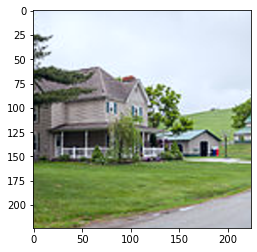

In [21]:
# process image 
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Green_Hills%2C_Pennsylvania_Mount_Road.jpg/220px-Green_Hills%2C_Pennsylvania_Mount_Road.jpg'
image = process_image(image_url)
top_prob, top_class = predict(image, model)
show_image(image)
print("The model is ", top_prob*100, "% certain that the image has a predicted class of ", top_class)

In [22]:
torch.save(model, 'fire_classifier')